# 02_Public Service DataSet Process and Analysis
#### Li Chen

To explore the relationship between housing prices and the delivery of public services within a specific community, I obtained data from a reliable and authoritative source: https://data.calgary.ca/. This data source is known for its accuracy and official status, making it a suitable foundation for analysis. 

The data downloaded directly from the source needs to undergo cleaning and transformation to enhance its usability for subsequent processing.

## PART I, Data Preprocessing

### 1, Geographical data process

- 1, Community Services, https://data.calgary.ca/Services-and-Amenities/Community-Services/x34e-bcjz/about_data. Contains hospitals, libraries, community centers and other public services in a community, locations are stored in spatial format.
- 2, Schools in Communities, https://data.calgary.ca/Services-and-Amenities/Schools-in-Communities/xmep-aasr. Contains schools information in a community, locations are stored in spatial format.

In [1]:
from shapely.geometry import Point, MultiPolygon
from shapely import wkt
import pandas as pd

In [7]:
## read the data
census = pd.read_csv('./Census.csv')
schools = pd.read_csv('./Schools.csv')
services = pd.read_csv('./Services.csv')

In [3]:
# define function that map points into community names

def inside(poly, point):
    for _poly in poly:
        if _poly.contains(point):
            return True
    return False

def get_comm_code(point, census_data):
    for index, row in census_data.iterrows():
        if row['poly'].contains(point):
            return row['COMM_CODE']
    return None
    
def to_poly(polygon_str):
    polygon = wkt.loads(polygon_str)
    if isinstance(polygon, MultiPolygon):
        multi_polygon = polygon
    else:
        multi_polygon = MultiPolygon([polygon])
    return multi_polygon
    
def to_point(point_str):
    coordinates = point_str.replace('POINT (', '').replace(')', '').split()
    x, y = map(float, coordinates)
    point = Point(x, y)
    return point


In [8]:
census['poly'] = census['multipolygon'].apply(lambda x: to_poly(x))
schools['point'] = schools['POINT'].apply(lambda x: to_point(x))
services['point'] = services['POINT'].apply(lambda x: to_point(x))

In [9]:
schools['comm_code'] = schools['point'].apply(lambda x: get_comm_code(x, census))
services['comm_code'] = services['point'].apply(lambda x: get_comm_code(x, census))

In [10]:
# export the data in order to migrate into database
schools.to_csv('./output/schools_with_comm_code.csv', index=False)
services.to_csv('./output/services_with_comm_code.csv', index=False)

### 2, Migrate to Database (PostgreSQL)

#### 2.1, Create tables and import data
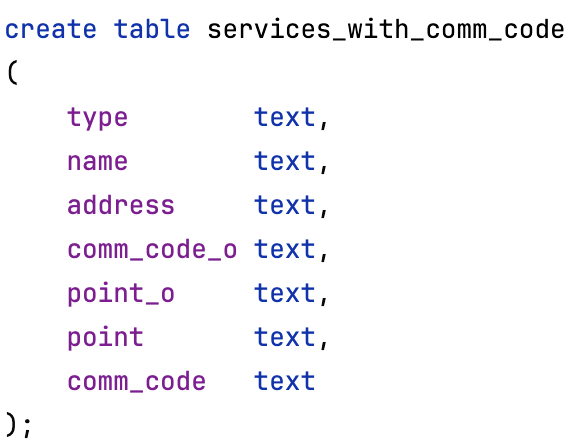

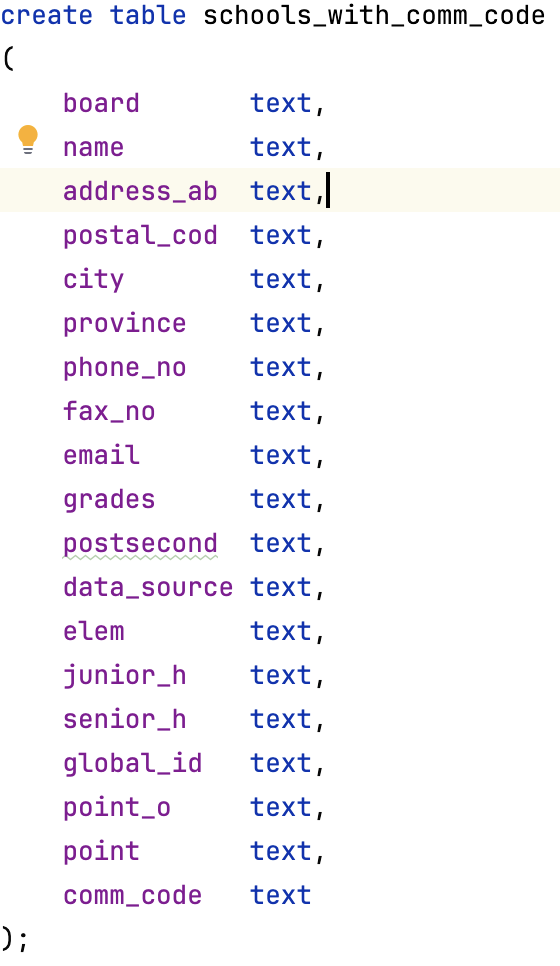

### 3, Data manipulating

#### 3.1, examine all public service types in the dataset

```
select distinct type from services_with_comm_code;
```

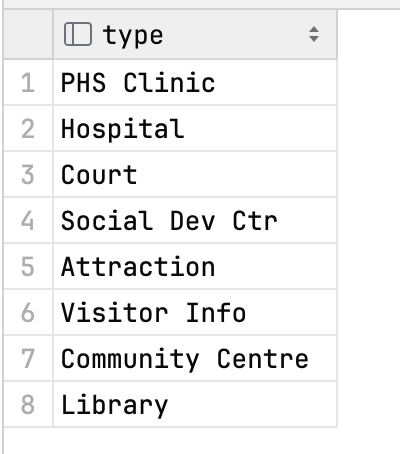

#### 3.2, examine all services in each community

```
select comm_code,type, count(1)
from services_with_comm_code
where comm_code is not null
group by comm_code,type;
```

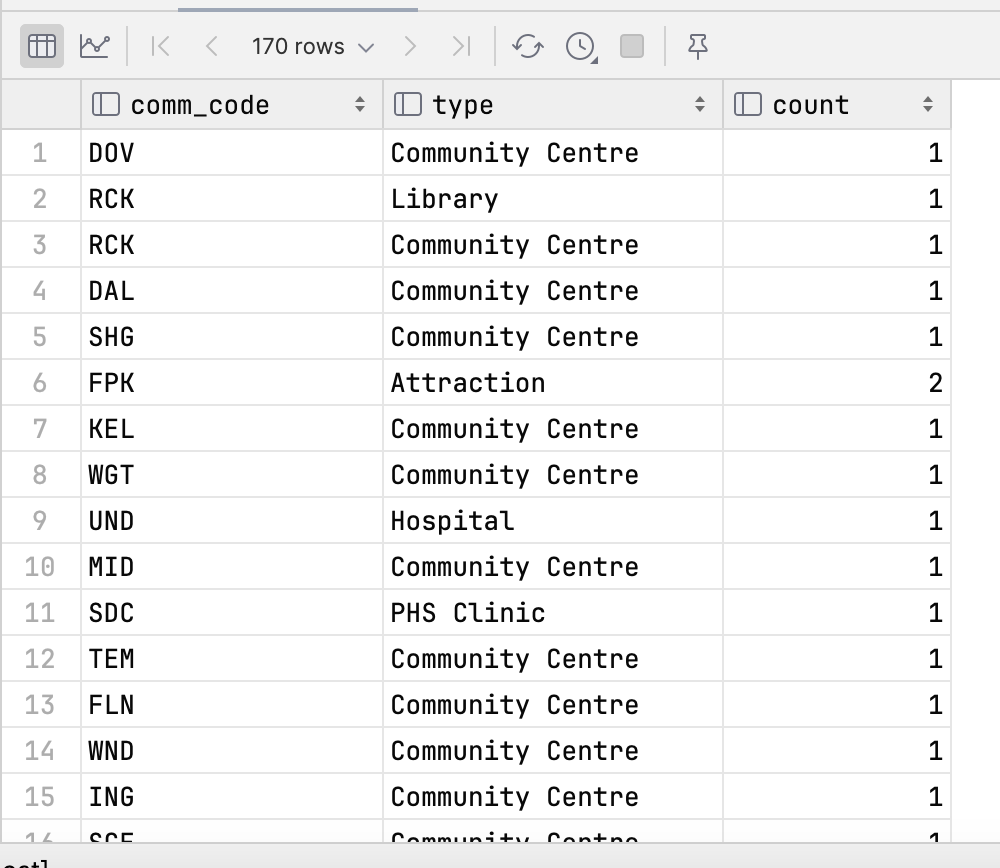

#### 3.3, examine school information from the dataset

```
select * from schools_with_comm_code;
```

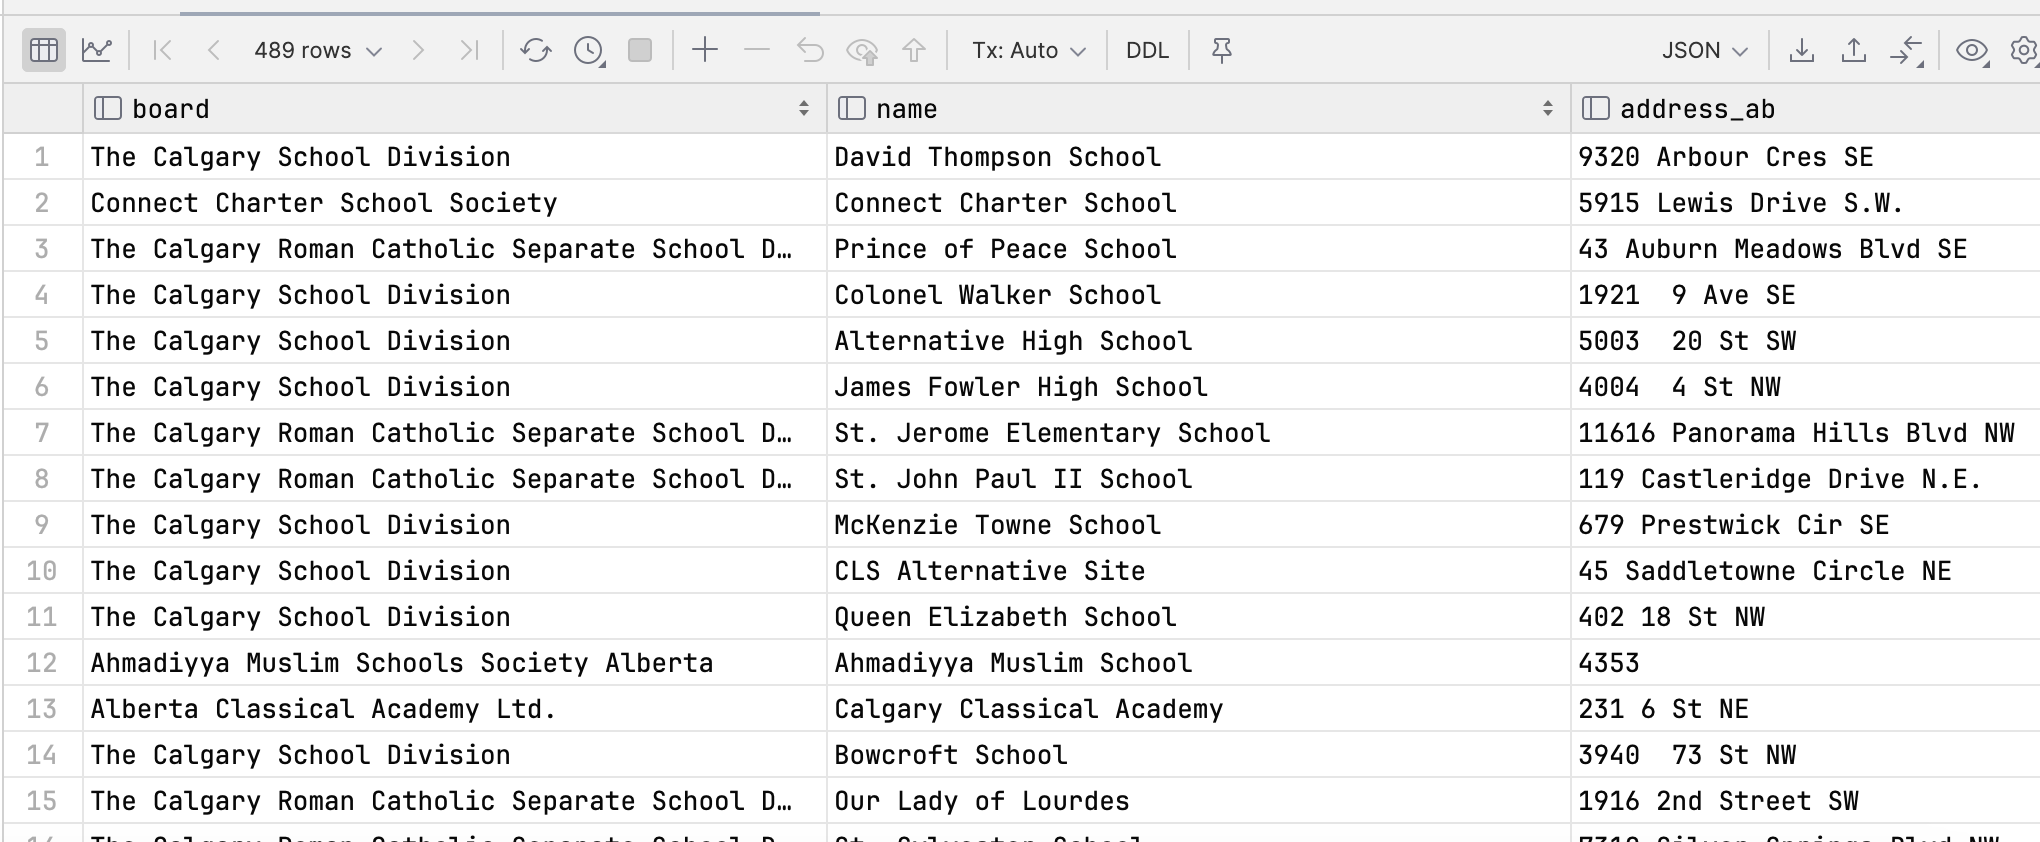

#### 3.4, examine the number of schools in each community with board information

```
select comm_code, board, count(1) from schools_with_comm_code
group by comm_code, board;
```

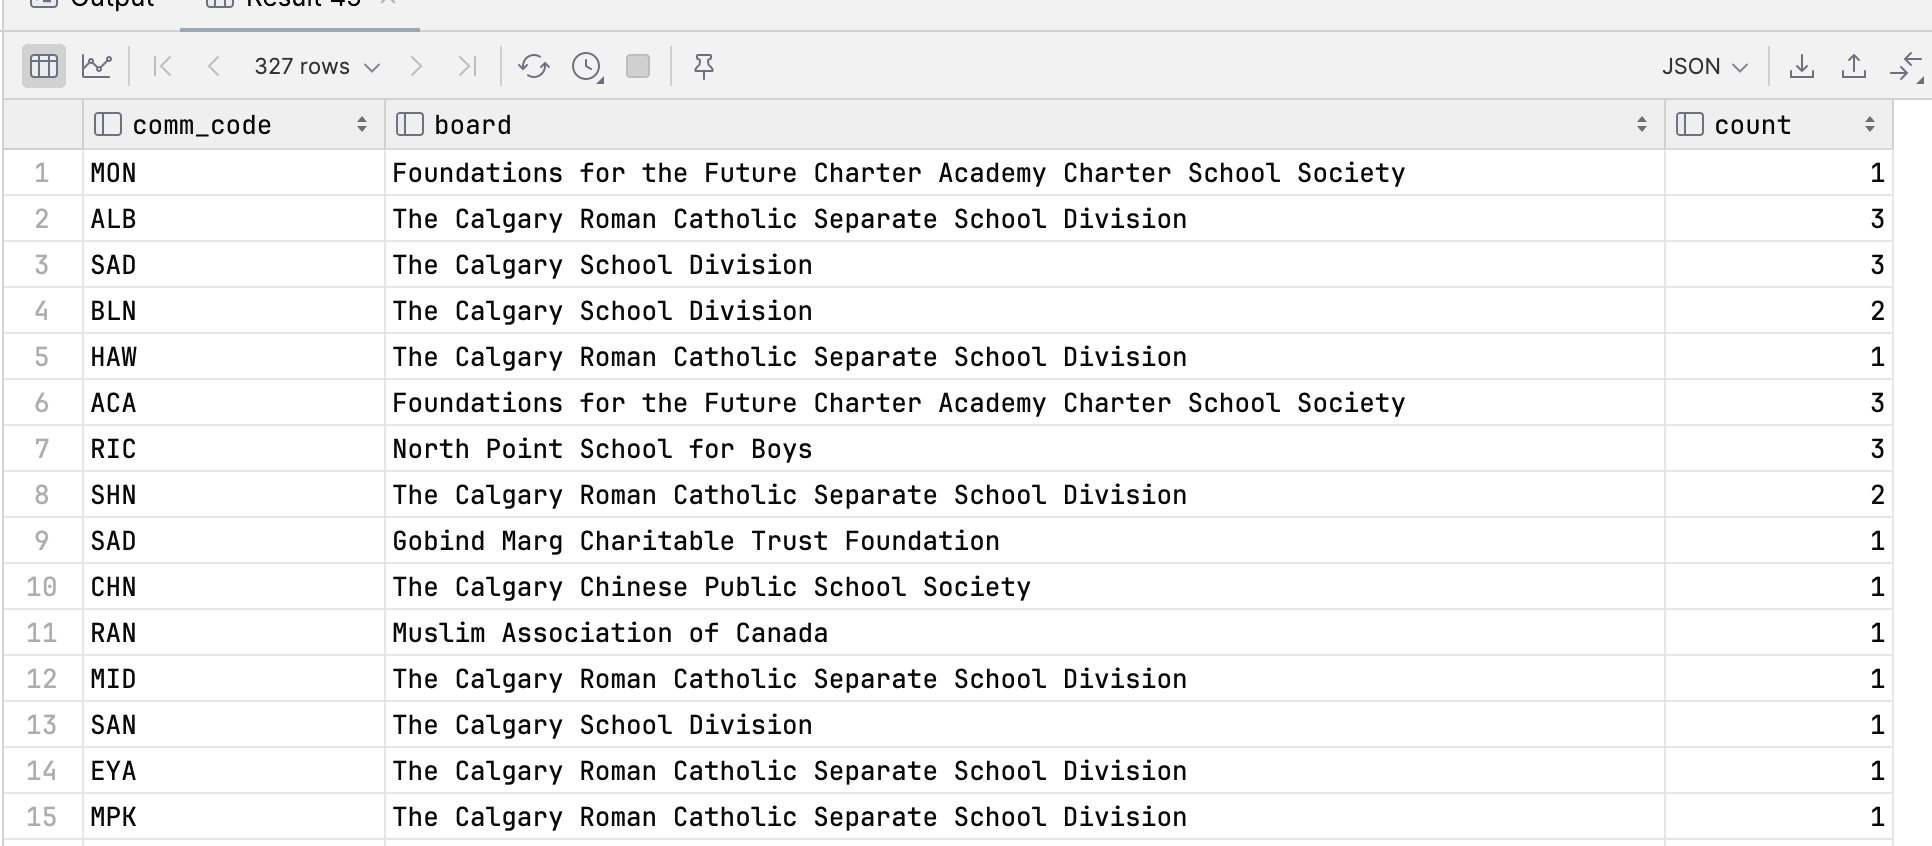

#### 3.5, manipulate data to add additional information to specify different school types in each community

```
select comm_code,
       count(CASE WHEN elem = 'Y' THEN 1 END) as Elementary,
       count(CASE WHEN junior_h = 'Y' THEN 1 END) as JuniorHigh,
       count(CASE WHEN senior_h = 'Y' THEN 1 END) as SeniorHigh
from schools_with_comm_code
group by comm_code;
```

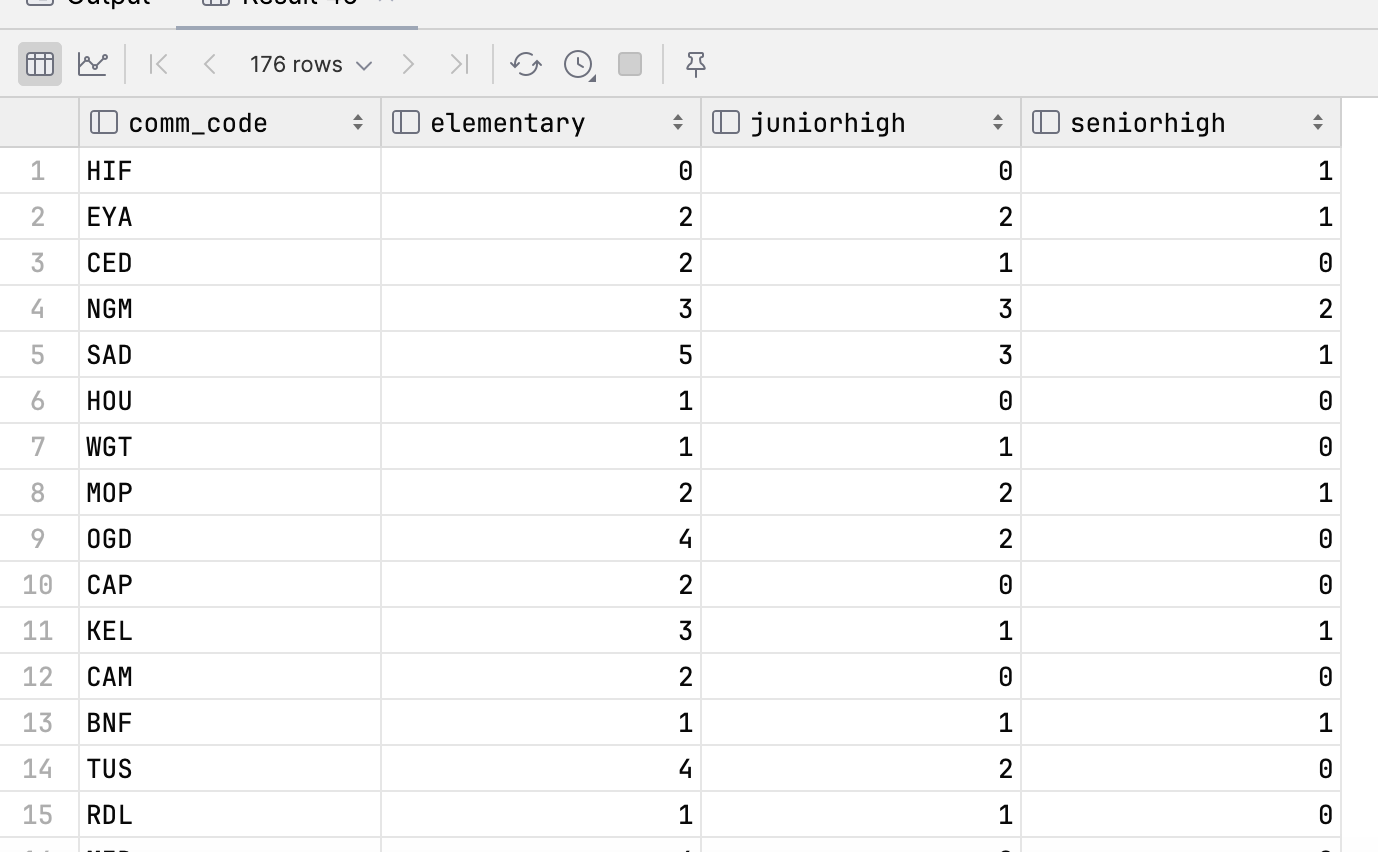

#### 3.6, create views for data useful for later analyse

For now, some of the fields are helpless in future works, in order to maintain the original structure of the data source, we can create views to hold the useful information instead of deleting them from the source.

For Services, community_Code will be retained, as well as service types
For Schools, community_Code, school types are retained.

```
create view service as
SELECT
    comm_code,
    SUM(CASE WHEN type = 'PHS Clinic' THEN 1 ELSE 0 END) AS PHS_Clinic,
    SUM(CASE WHEN type = 'Hospital' THEN 1 ELSE 0 END) AS Hospital,
    SUM(CASE WHEN type = 'Court' THEN 1 ELSE 0 END) AS Court,
    SUM(CASE WHEN type = 'Social Dev Ctr' THEN 1 ELSE 0 END) AS Social_dev_ctr,
    SUM(CASE WHEN type = 'Attraction' THEN 1 ELSE 0 END) AS attaction,
    SUM(CASE WHEN type = 'Visitor Info' THEN 1 ELSE 0 END) AS Visitor_Info,
    SUM(CASE WHEN type = 'Community Centre' THEN 1 ELSE 0 END) AS commu_center,
    SUM(CASE WHEN type = 'Library' THEN 1 ELSE 0 END) AS Library
FROM
    services_with_comm_code
GROUP BY
    comm_code;

create view school as
select comm_code,
       count(CASE WHEN elem = 'Y' THEN 1 END) as Elementary,
       count(CASE WHEN junior_h = 'Y' THEN 1 END) as JuniorHigh,
       count(CASE WHEN senior_h = 'Y' THEN 1 END) as SeniorHigh
from schools_with_comm_code
group by comm_code;

-- combine the data using comm_code as key
create view final_data as
    select tb1.*, tb2.Elementary,tb2.JuniorHigh,tb2.SeniorHigh
    from service tb1, school tb2
where tb1.comm_code = tb2.comm_code;

select * from final_data

```

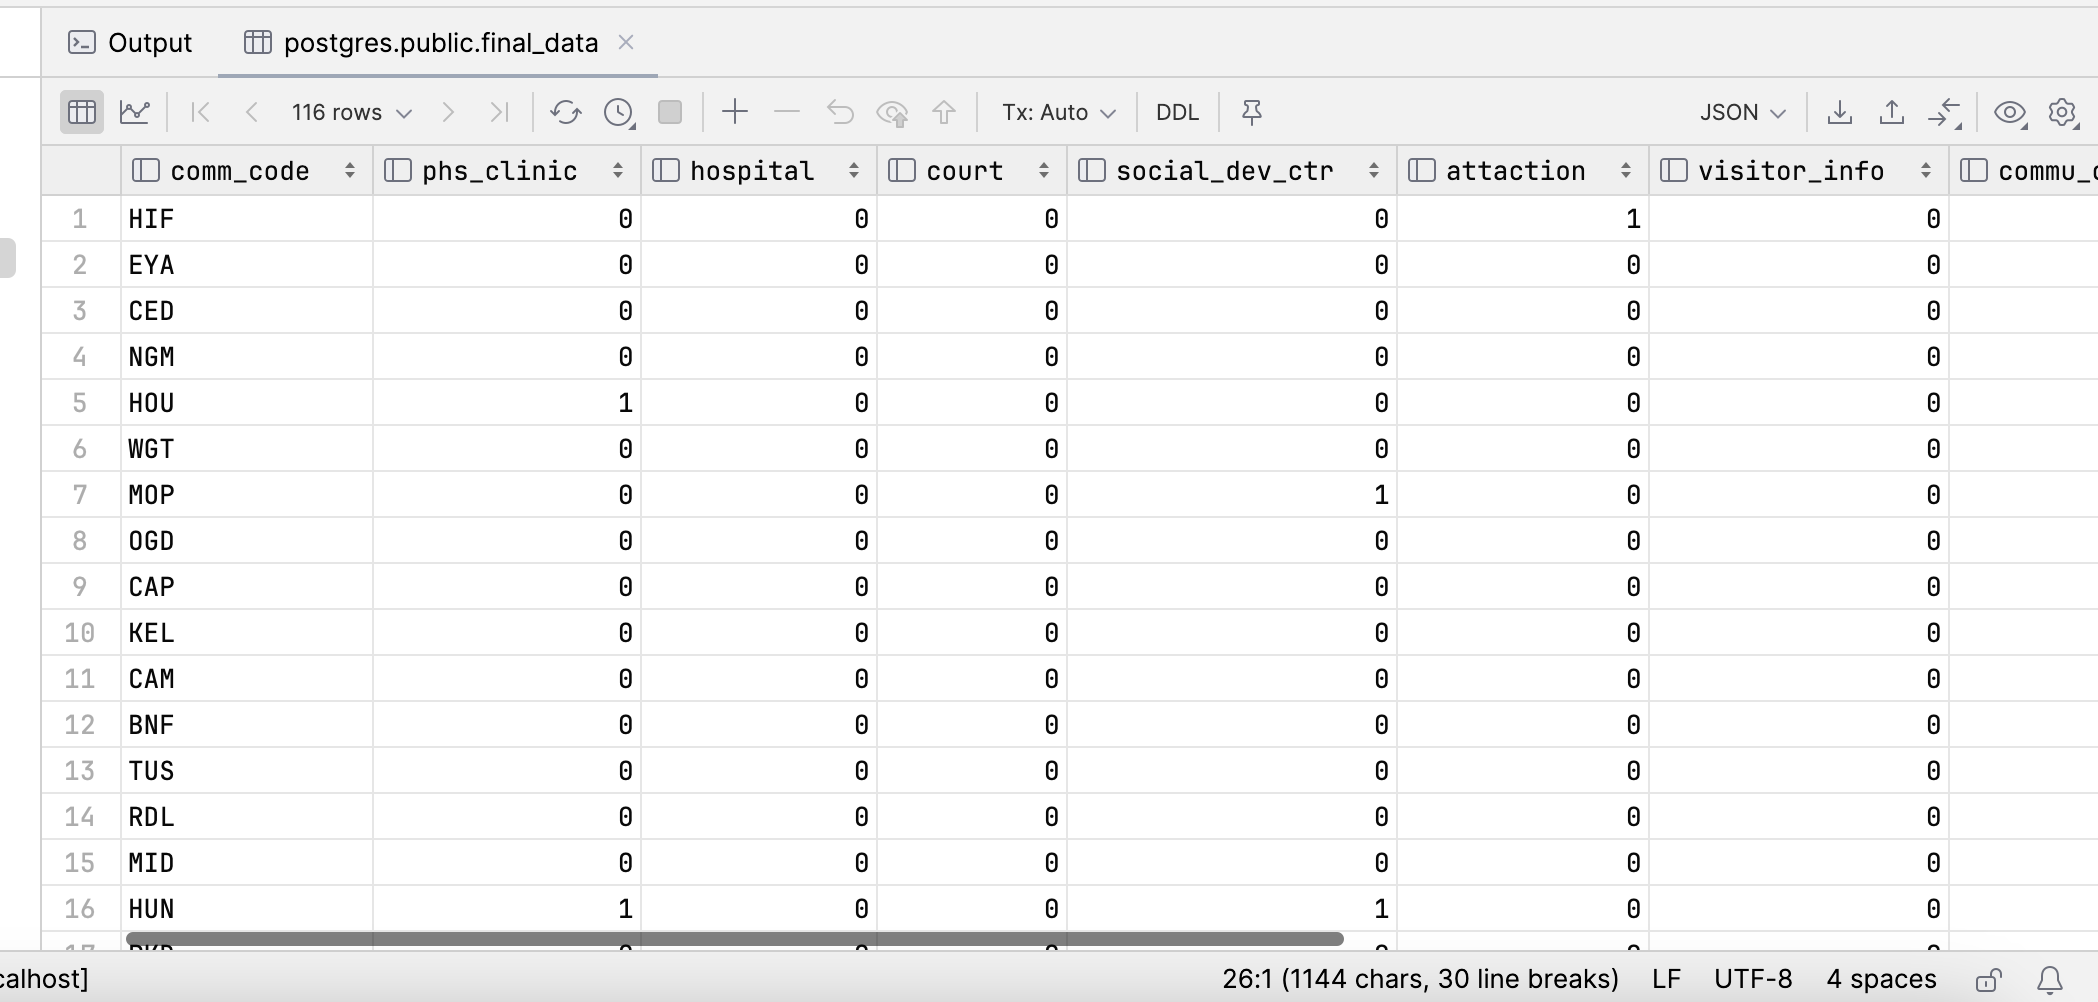

Thus, the preliminary cleaning is done. The data is ready to merge with the results from other team members for further analyze.

## PART II, Analysing

### 1, Read data from local database (PostgreSQL)

In [ ]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://lichen@localhost:5432/postgres')
sql = "SELECT * FROM PUBLIC_SERVICE"
df = pd.read_sql_query(sql, engine)
communities = pd.read_sql_query("select * from COMMUNITY", engine)

df = pd.merge(df, communities, on='comm_code', how='outer')

In [ ]:
df[df['elementary'].notnull()]

,comm_code,elementary,juniorhigh,seniorhigh,phs_clinic,hospital,court,social_dev_ctr,attaction,visitor_info,commu_center,library,multipolygon_x,re_value,re_unit_price,multipolygon_y
43,ABB,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-113.9204713 51.0565991, -113....",302865.032487,758.790081,"MULTIPOLYGON (((-113.9204713 51.0565991, -113...."
45,ACA,8.0,6.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-114.0715968 50.9650396, -114....",433786.875000,814.490423,"MULTIPOLYGON (((-114.0715968 50.9650396, -114...."
46,ALB,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-114.0130939 51.0373573, -114....",345562.785388,733.248167,"MULTIPOLYGON (((-114.0130939 51.0373573, -114...."
50,ARB,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,"MULTIPOLYGON (((-114.1899838 51.1433272, -114....",561150.174825,1038.594298,"MULTIPOLYGON (((-114.1899838 51.1433272, -114...."
55,BED,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-114.065193 51.132128, -114.06...",375325.471698,886.281854,"MULTIPOLYGON (((-114.065193 51.132128, -114.06..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,WIL,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"MULTIPOLYGON (((-114.0712779 50.9519951, -114....",620798.300818,910.032691,"MULTIPOLYGON (((-114.0712779 50.9519951, -114...."
305,WIN,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-114.0383451 51.0814869, -114....",544033.461538,141.343159,"MULTIPOLYGON (((-114.0383451 51.0814869, -114...."
306,WLD,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-114.1411772 51.0531883, -114....",750075.144509,1231.077149,"MULTIPOLYGON (((-114.1411772 51.0531883, -114...."
307,WND,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((-114.0761974 51.0013713, -114....",688109.634551,975.831192,"MULTIPOLYGON (((-114.0761974 51.0013713, -114...."


### 2, General perception of the distribution of public services in communities

<Axes: >

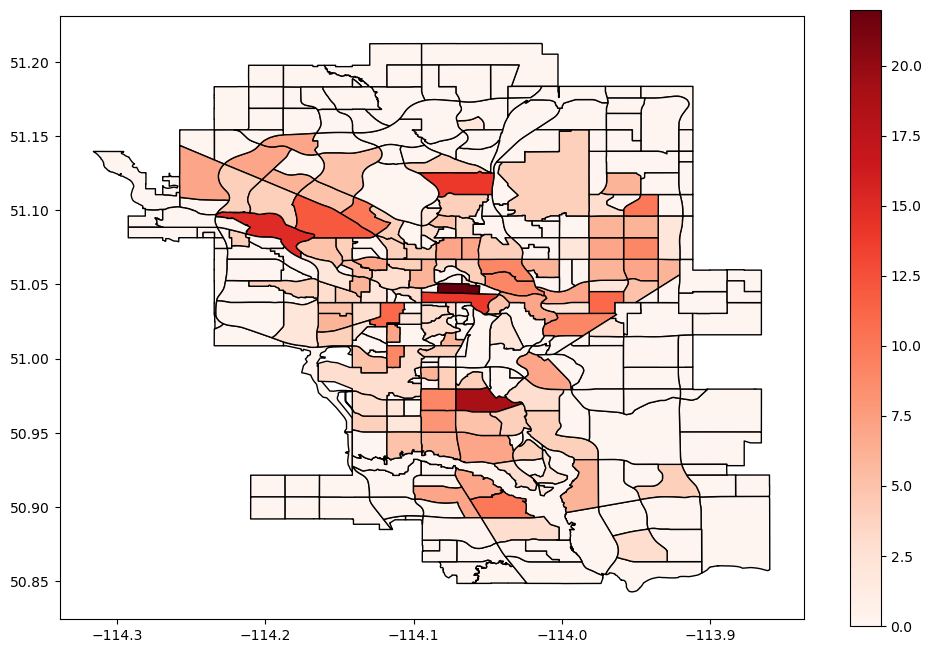

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
df['multipolygon'] = df['multipolygon_y'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='multipolygon')
# gdf.fillna(0, inplace=True)
gdf['total_services'] = gdf[['elementary', 'juniorhigh', 'seniorhigh', 'phs_clinic', 'hospital', 'court', 'social_dev_ctr', 'attaction', 'visitor_info', 'commu_center', 'library']].sum(axis=1)
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column='total_services', ax=ax, legend=True, cmap='Reds',edgecolor='black')


As shown in the plot, the public services scatterd unevenly in Calgary, therefore, we can dive into each category of the services.

### 3, Visualize the distribution of each public service type

First, We need to fill the null data in advance.

In [ ]:
data = df.drop(columns=['multipolygon_x', 'multipolygon_y', 'multipolygon'])
data.dropna(subset=['re_value'], inplace=True)
data.dropna(subset=['re_unit_price'], inplace=True)
factors = ['elementary', 'juniorhigh', 'seniorhigh', 'phs_clinic','hospital', 'court', 'social_dev_ctr', 'attaction', 'visitor_info','commu_center', 'library','re_value']
data.loc[:, factors] = data[factors].fillna(0)

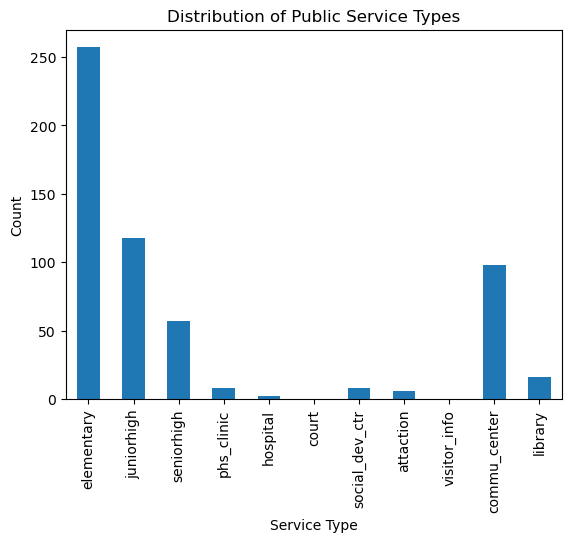

In [ ]:
service_counts = data[['elementary', 'juniorhigh', 'seniorhigh', 'phs_clinic', 'hospital', 'court', 'social_dev_ctr', 'attaction', 'visitor_info', 'commu_center', 'library']].sum()
service_counts.plot(kind='bar')
plt.title('Distribution of Public Service Types')
plt.xlabel('Service Type')
plt.ylabel('Count')
plt.show()

We can find out that schools consists most of the data. We can now investigate schools in communities on geo-graphic plot. In order to maintain stringency, only communities that without missing data are plotted.

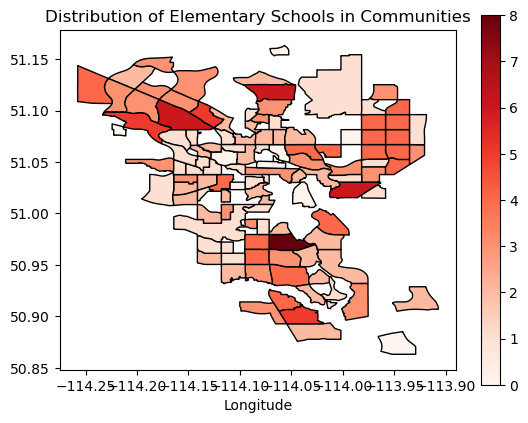

In [ ]:
fig, ax = plt.subplots(1, 1)
gdf.plot(column='elementary', ax=ax, legend=True, cmap='Reds',edgecolor='black')
plt.title('Distribution of Elementary Schools in Communities')
plt.xlabel('Longitude')
plt.show()

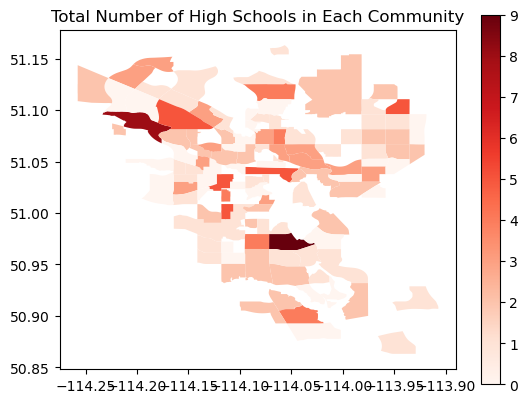

In [ ]:
gdf['total_high'] = gdf['juniorhigh'] + gdf['seniorhigh']
fig, ax = plt.subplots(1, 1)
gdf.plot(column='total_high', ax=ax, legend=True, cmap='Reds')
plt.title('Total Number of High Schools in Each Community')
plt.show()

<Axes: title={'center': 'Average Number of Schools in Each Community by Type'}, xlabel='School Type', ylabel='Average Number of Schools'>

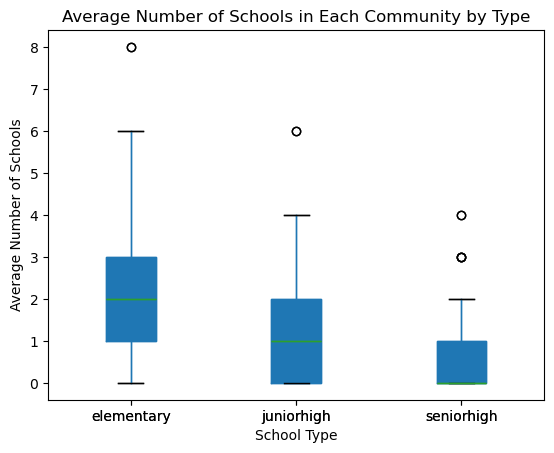

In [ ]:
avg_schools = df.groupby('comm_code')[['elementary', 'juniorhigh', 'seniorhigh']].mean()
fig, ax = plt.subplots()
avg_schools.boxplot(ax=ax)
ax.set_xlabel('School Type')
ax.set_ylabel('Average Number of Schools')
ax.set_title('Average Number of Schools in Each Community by Type')
avg_schools.boxplot(ax=ax, grid=False, patch_artist=True)


### 4, Discover other public service facilities

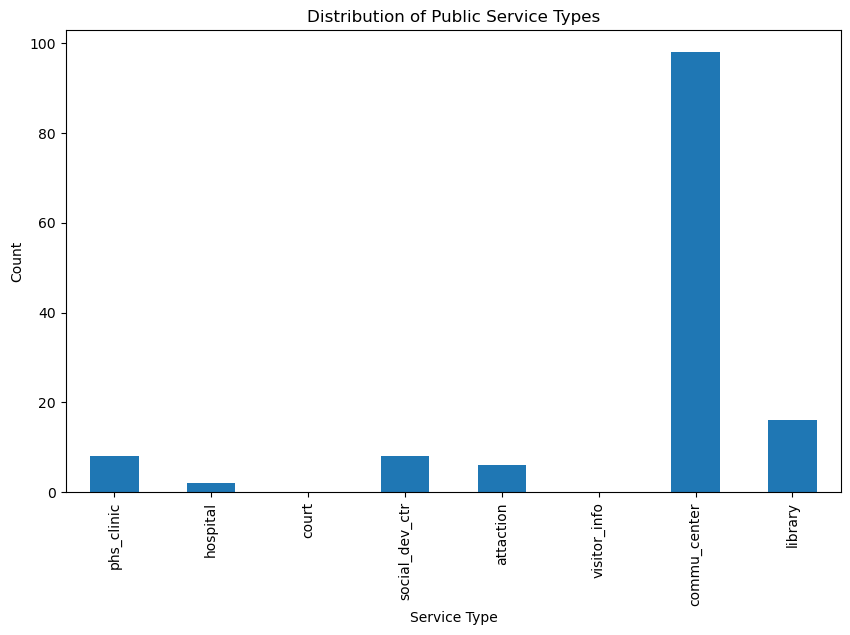

In [ ]:
service_counts = data[['phs_clinic', 'hospital', 'court', 'social_dev_ctr', 'attaction', 'visitor_info', 'commu_center', 'library']]
fig, ax = plt.subplots(figsize=(10, 6))
service_counts.sum().plot(kind='bar', ax=ax)
plt.title('Distribution of Public Service Types')
plt.xlabel('Service Type')
plt.ylabel('Count')
plt.show()

As court, vistor_info are nearly zero in numbers, therefore we should drop those in future analyze.

In [ ]:
# discard court and vistor_info
factors = ['elementary', 'juniorhigh', 'seniorhigh', 'phs_clinic','hospital', 'social_dev_ctr', 'attaction','commu_center', 'library','re_value','re_unit_price']


### 5, Explore the relations with property value

First we can explore the relations between property value and the types of public services.
Before that, the value and value/suqare ft need to be normalized.  

In [ ]:
data['re_value'] = (data['re_value'] - data['re_value'].min()) / (data['re_value'].max() - data['re_value'].min())
data['re_unit_price'] = (data['re_unit_price'] - data['re_unit_price'].min()) / (data['re_unit_price'].max() - data['re_unit_price'].min())


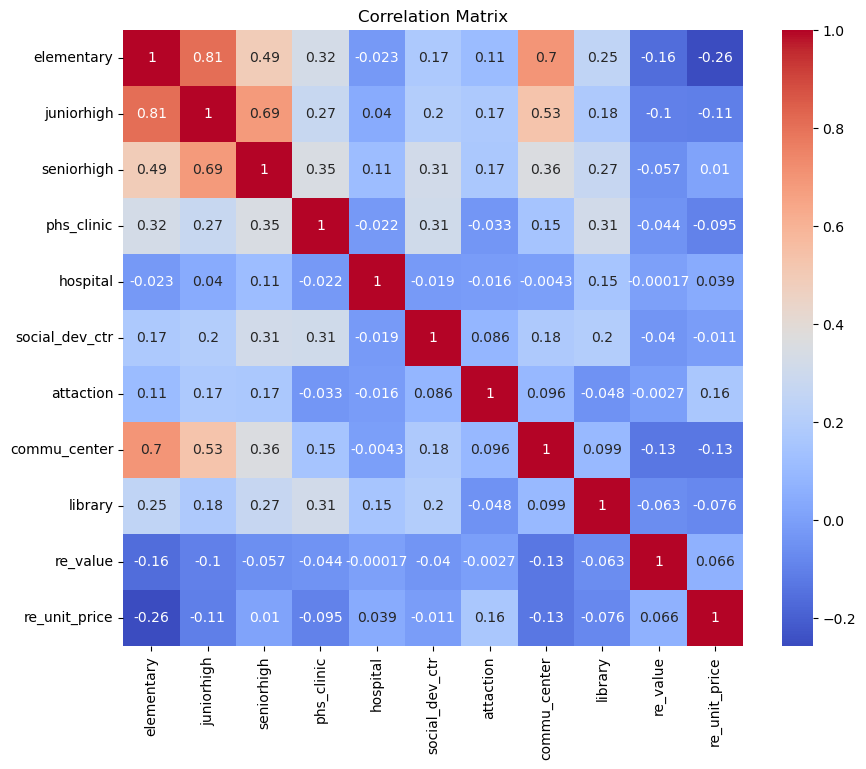

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = data[factors].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


We can identify that the factors do not have significant impact with property value and value/square.  
But we can find other features tend to have strong relations, for example, clinc and library, schools and clinics.

In order to have a more statistical meaning of the exploration, we can using statistical method in DATA-603 to analyze the data.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

X = data[['elementary', 'juniorhigh', 'seniorhigh', 'phs_clinic', 'hospital', 'court', 'social_dev_ctr', 'attaction', 'visitor_info', 'commu_center', 'library']]
y = data['re_unit_price']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          re_unit_price   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.044
Date:                Thu, 28 Mar 2024   Prob (F-statistic):            0.00206
Time:                        10:53:50   Log-Likelihood:                 142.95
No. Observations:                 188   AIC:                            -265.9
Df Residuals:                     178   BIC:                            -233.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2832      0.012     22.

As shown in the table, attraction and schools seems to have relations with the price at 0.05 level of signifigance. 

So, we can investigate the prices related to school and attraction information

#### 5.1, Schools vs No-Schools

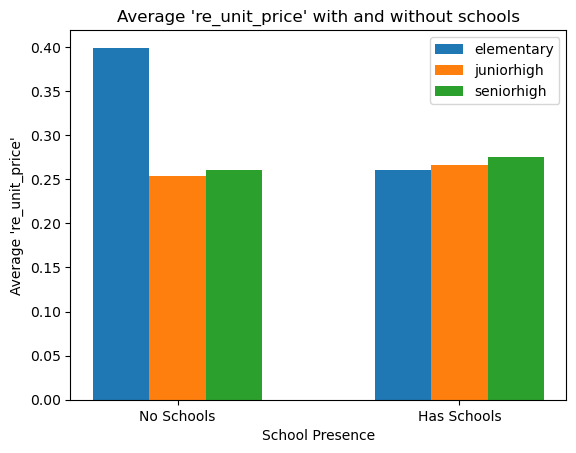

In [ ]:
import numpy as np

school_types = ['elementary', 'juniorhigh', 'seniorhigh']
labels = ['No Schools', 'Has Schools']
width = 0.2 
fig, ax = plt.subplots()

for i, school in enumerate(school_types):
    grouped_data = data.groupby(data[school]!=0)['re_unit_price'].mean()
    ax.bar(np.arange(len(labels)) + i*width, grouped_data, width, label=school)

ax.set_xticks(np.arange(len(labels)) + width)
ax.set_xticklabels(labels)
ax.set_title("Average 're_unit_price' with and without schools")
ax.set_xlabel("School Presence")
ax.set_ylabel("Average 're_unit_price'")

ax.legend()
plt.show()

#### 5.2, Attraction vs No-attraction

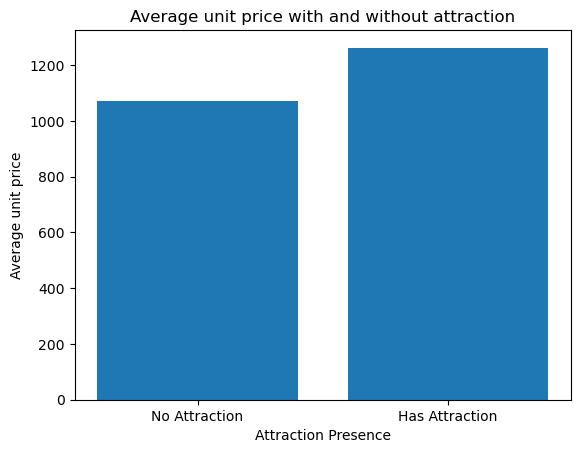

In [ ]:
labels = ['No Attraction', 'Has Attraction']
grouped_data = df.groupby(df['attaction']!=0)['re_unit_price'].mean()

fig, ax = plt.subplots()
ax.bar(labels, grouped_data)
ax.set_title("Average unit price with and without attraction")
ax.set_xlabel("Attraction Presence")
ax.set_ylabel("Average unit price")
plt.show()

In the chart, it's noticeable that residential unit prices tend to be higher in areas with attractions or without elementary schools, whereas prices exhibit less variance between communities with and without junior and senior high schools.

Moreover, communities with high schools appear to have slightly higher unit prices compared to those without. One possible explanation for this trend is that communities without elementary schools may have lower population density, influencing property values. As for high schools, their distribution tends to be more dispersed, resulting in average prices reflecting the broader market trends rather than localized factors.

To further enhance this analysis:

- Consider examining additional demographic or socioeconomic factors that may contribute to variations in residential property prices.
- Investigate potential correlations between school quality, academic performance, and residential property prices to gain deeper insights into the observed trends.